In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


Aquí introducimos las siguientes direcciones donde están almacenadas las imágenes en subcarpetas

In [3]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join(base_dir, 'train5k_5cat')
test_dir = os.path.join( base_dir,'test1k_5cat')


In [4]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
train_2 = os.path.join(train_dir, '2') 
train_3 = os.path.join(train_dir, '3')  
train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
val_2 = os.path.join(val_dir, '2') 
val_3 = os.path.join(val_dir, '3')  
val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
num_2_tr = len(os.listdir(train_2))
num_3_tr = len(os.listdir(train_3))
num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
num_2_v = len(os.listdir(val_2))
num_3_v = len(os.listdir(val_3))
num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr + num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v + num_2_v + num_3_v + num_4_v
 

Usamos el imageDataGenerator para poder ir leyendo cada batch de imágenes en el conjunto de entrenamiento

In [5]:
#augmentación para set de entrenamiento 
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      fill_mode='nearest' )

train_data_gen = image_gen_train.flow_from_directory(batch_size=32,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(299,299),
                                                     class_mode='sparse')

Found 2129 images belonging to 5 classes.


Usamos el imageDataGenerator para poder ir leyendo cada batch de imágenes en el conjunto de validación

In [5]:
image_gen_test = ImageDataGenerator(
    rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                                 directory=val_dir,
                                                 target_size=(299,299),
                                                 class_mode='sparse')

Found 377 images belonging to 5 classes.


Estamos usando el mismo modelo que funcinó con la clasificación entre 5 tipos de flores

In [11]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 146, 146, 64)      9280      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 128)      

Entrenamos usando la gpu para que sea más rápido, usando los datasets que nos proporciona cada imageDatagenerator  para el conjunto de entrenamiento y validación, así como un tamaño de batch de 32 y 200 épocas

In [12]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(32))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(32)))
    )

Train for 67 steps, validate for 12 steps
Epoch 1/200
67/67 [==============================] - 9s 137ms/step - loss: 1.4902 - accuracy: 0.3729 - val_loss: 1.5514 - val_accuracy: 0.3448
Epoch 2/200
67/67 [==============================] - 9s 129ms/step - loss: 1.4861 - accuracy: 0.3758 - val_loss: 1.4958 - val_accuracy: 0.3740
Epoch 3/200
67/67 [==============================] - 9s 129ms/step - loss: 1.4686 - accuracy: 0.3852 - val_loss: 1.4887 - val_accuracy: 0.3714
Epoch 4/200
67/67 [==============================] - 9s 128ms/step - loss: 1.4592 - accuracy: 0.4176 - val_loss: 1.4962 - val_accuracy: 0.3554
Epoch 5/200
67/67 [==============================] - 9s 129ms/step - loss: 1.4525 - accuracy: 0.4265 - val_loss: 1.4888 - val_accuracy: 0.3952
Epoch 6/200
67/67 [==============================] - 9s 129ms/step - loss: 1.4446 - accuracy: 0.4420 - val_loss: 1.4942 - val_accuracy: 0.3846
Epoch 7/200
67/67 [==============================] - 9s 129ms/step - loss: 1.4385 - accuracy: 0.4401

Epoch 114/200
67/67 [==============================] - 9s 128ms/step - loss: 1.2205 - accuracy: 0.6858 - val_loss: 1.4858 - val_accuracy: 0.4111
Epoch 115/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2271 - accuracy: 0.6797 - val_loss: 1.4974 - val_accuracy: 0.3979
Epoch 116/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2280 - accuracy: 0.6773 - val_loss: 1.4827 - val_accuracy: 0.4085
Epoch 117/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2232 - accuracy: 0.6844 - val_loss: 1.5074 - val_accuracy: 0.3873
Epoch 118/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2275 - accuracy: 0.6797 - val_loss: 1.4823 - val_accuracy: 0.4138
Epoch 119/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2201 - accuracy: 0.6867 - val_loss: 1.4886 - val_accuracy: 0.4111
Epoch 120/200
67/67 [==============================] - 9s 129ms/step - loss: 1.2180 - accuracy: 0.6900 - val_loss: 1.4951 - val_ac

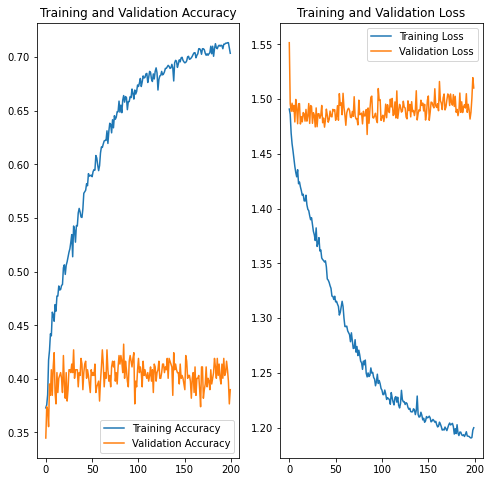

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como podemos apreciar los resultados son horribles para el conjunto de validación, estamos cayendo en un sobreaprendizage muy severo, ya que el conjunto de entrenamiento tiene una continua mejora sin ninguna mejora significativa del conjunto de validación.

Podriamos tratar de evitarlo aumentando el conjunto de datos sobre el que entrenar, ya sea usando mayor cantidad de datos, o usando augmentación para los datos que ya tenemos

Los resultados son pobres, sobre el conjunto de datos que hemos usado, el cual es una versión muy reducida del conjunto de imágenes kaggle, el cual hemos balanceado teniendo: 2129 imágenes para el entrenamiento y 377  imágenes diferentes para validación.

In [9]:
# Guardar el Modelo
model.save('miniprueba2.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')